# Práctica 5

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import pandas as pd
import math

Generamos los puntos aleatoriamente, para poder graficar la distribución. Como queremos obtener 160 puntos, esos serán el número de `bins`.

In [2]:
points = np.random.rayleigh(scale=7.53, size=100000)
bins = 160
y, X = np.histogram(points, bins=bins, density=True)

# Since |X| - 1 = |Y| 
X = X[:-1]

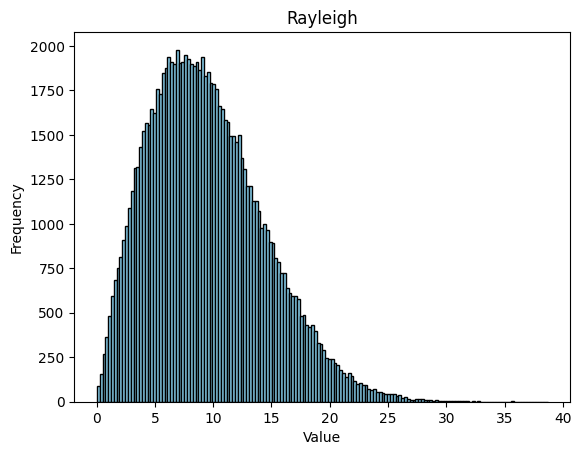

In [3]:
plt.hist(points, bins=bins, color='skyblue', edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Rayleigh')

plt.show()

## Generando modelos con regresión polinomial

Vamos a generar modelos usando regresión polinomial, entrenando el modelo en una sola ronda.

In [4]:
def create_metrics_dataframe(
    model, X_test, y_test, index
):
    '''Creates a dataframe with MSE, R2 and MAE metrics.'''
    
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    bias = np.mean((y_test - np.mean(y_pred, axis=0)) ** 2)
    variance = np.var(y_pred)
    
    columns = ['MSE', 'R2', 'MAE', 'Bias', 'Variance']
    
    data = [[mse, r2, mae, bias, variance]]
    return pd.DataFrame(data, columns=columns, index=[index])

def calculate_X_poly(X, degree):
    '''Converts one dimensional X to a polynomial features.'''

    poly_features = PolynomialFeatures(degree=degree)
    X_poly = poly_features.fit_transform(X.reshape(-1, 1))
    return X_poly

def polynomial_regression(X: np.array, Y: np.array, degree: int):
    '''Creates a polynomial regression model.'''

    X_poly = calculate_X_poly(X, degree)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)

    df = create_metrics_dataframe(model, X_test, y_test, index=degree)

    return model, df

Generamos hasta un polinomio de grado 20.

In [5]:
metrics = pd.DataFrame()
for degree in range(1, 20):
    _, model_metrics = polynomial_regression(X, y, degree)
    metrics = pd.concat([metrics, model_metrics])

metrics

,MSE,R2,MAE,Bias,Variance
1,2.139570e-04,0.764516,0.012181,0.000910,0.000471
2,2.331970e-04,0.743340,0.013039,0.000909,0.000462
3,9.606174e-05,0.894273,0.008090,0.000914,0.000721
4,1.064150e-05,0.988288,0.002946,0.000909,0.000918
5,6.841876e-06,0.992470,0.002123,0.000909,0.000952
6,2.544355e-06,0.997200,0.001328,0.000909,0.000941
7,6.230164e-07,0.999314,0.000573,0.000909,0.000916
8,5.917557e-07,0.999349,0.000507,0.000909,0.000920
9,5.954384e-07,0.999345,0.000516,0.000909,0.000912
10,1.312658e-06,0.998555,0.000964,0.000909,0.000926


## Creando modelos usando validación cruzada

Vamos a usar regularización con validación cruzada para mejorar las predicciones de nuestros modelos.

In [11]:
def cv_polinomial_regression(X, y, degree, model_parameters, k_folds):
    '''Creates a polynomial regression model using cross validation for training.'''

    X_poly = calculate_X_poly(X, degree)
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    # Ridge allows to use l2 regularization
    model = Ridge()

    gs = GridSearchCV(model, param_grid=model_parameters, cv=k_folds, scoring="neg_mean_squared_error")
    gs.fit(X_train, y_train)
    
    df = create_metrics_dataframe(gs, X_test, y_test, index=degree)

    return model, df
    

In [12]:
cv_metrics = pd.DataFrame()
parameters = {"alpha": [1e-8, 1e-6, 1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 1e-2, 1e-1, 1.0]}
for degree in range(1, 20):
    _, model_metrics = cv_polinomial_regression(X, y, degree=degree, model_parameters=parameters, k_folds=30)
    cv_metrics = pd.concat([cv_metrics, model_metrics])

cv_metrics

/home/luis/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.82787e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/luis/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.85312e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/luis/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.86471e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/luis/miniconda3/envs/ml/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=2.87569e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/home/luis/minic

,MSE,R2,MAE,Bias,Variance
1,2.139713e-04,0.764500,0.012181,0.000910,0.000471
2,2.332523e-04,0.743279,0.013041,0.000909,0.000462
3,9.586946e-05,0.894485,0.008078,0.000914,0.000720
4,1.061728e-05,0.988314,0.002942,0.000909,0.000917
5,6.819121e-06,0.992495,0.002147,0.000909,0.000950
6,2.547544e-06,0.997196,0.001338,0.000909,0.000939
7,6.230224e-07,0.999314,0.000573,0.000909,0.000916
8,5.916481e-07,0.999349,0.000507,0.000909,0.000920
9,5.988093e-07,0.999341,0.000515,0.000909,0.000914
10,6.311057e-07,0.999305,0.000517,0.000909,0.000915


In [8]:
metrics.reset_index(drop=True, inplace=True)
cv_metrics.reset_index(drop=True, inplace=True)
separator_column = pd.DataFrame({'Separator': [''] * len(cv_metrics)})

pd.concat([metrics, separator_column, cv_metrics], axis=1)

,MSE,R2,MAE,Bias,Variance,Separator,MSE,R2,MAE,Bias,Variance
0,2.139570e-04,0.764516,0.012181,0.000910,0.000471,,2.139713e-04,0.764500,0.012181,0.000910,0.000471
1,2.331970e-04,0.743340,0.013039,0.000909,0.000462,,2.332523e-04,0.743279,0.013041,0.000909,0.000462
2,9.606174e-05,0.894273,0.008090,0.000914,0.000721,,9.586946e-05,0.894485,0.008078,0.000914,0.000720
3,1.064150e-05,0.988288,0.002946,0.000909,0.000918,,1.061728e-05,0.988314,0.002942,0.000909,0.000917
4,6.841876e-06,0.992470,0.002123,0.000909,0.000952,,6.819121e-06,0.992495,0.002147,0.000909,0.000950
5,2.544355e-06,0.997200,0.001328,0.000909,0.000941,,2.547544e-06,0.997196,0.001338,0.000909,0.000939
6,6.230164e-07,0.999314,0.000573,0.000909,0.000916,,6.230224e-07,0.999314,0.000573,0.000909,0.000916
7,5.917557e-07,0.999349,0.000507,0.000909,0.000920,,5.916481e-07,0.999349,0.000507,0.000909,0.000920
8,5.954384e-07,0.999345,0.000516,0.000909,0.000912,,5.988093e-07,0.999341,0.000515,0.000909,0.000914
9,1.312658e-06,0.998555,0.000964,0.000909,0.000926,,6.311057e-07,0.999305,0.000517,0.000909,0.000915


## Usando el Estimador de Máxima Verosimilitud

In [9]:
class RayleighMLE:
    def calculate_sigma(self, X):
        self.sigma = math.sqrt((np.sum(X**2)/2*(len(X))))

    def _rayleigh(self, x):
        return x/(self.sigma ** 2) * np.exp((-x**2)/(2 * self.sigma**2))
    
    def predict(self, X):
        return self._rayleigh(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rayleigh_mle = RayleighMLE()
rayleigh_mle.calculate_sigma(X_train)
create_metrics_dataframe(rayleigh_mle, X_test=X_test, y_test=y_test, index=0)

,MSE,R2,MAE,Bias,Variance
0,0.001693,-0.863771,0.028014,0.001693,7.205660e-12
